In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [3]:
df = pd.read_parquet('data/states_prepared.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


## Podział

In [4]:
df.columns

Index(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       'tAlivePlayers', 'tEqVal', 'bombsite', 'ct_hp', 't_hp', 'ct_armor',
       't_armor', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_

In [5]:
def select_feat(prep_df):
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 'ct_mainWeapon_Others',
       't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle',
       't_mainWeapon_Others', 'ct_secondaryWeapon_Pistol',
       'ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'de_ancient',
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return prep_df[columns]

In [6]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')

df_train, df_test = df.loc[~filtr], df.loc[filtr]

In [7]:
match_map = df_train.groupby(['filename', 'mapName']).indices
len(match_map.keys())

299

In [8]:
maps = len(match_map.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.9*maps), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(match_map):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, match_map[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, match_map[key]))

train_indexes.shape

(2594070,)

In [9]:
df_valid = df_train.iloc[valid_indexes]
df_valid['winningSideCT'].value_counts(normalize=True)

1    0.524193
0    0.475807
Name: winningSideCT, dtype: float64

In [10]:
df_train = df_train.iloc[train_indexes]
df_train['winningSideCT'].value_counts(normalize=True)

1    0.523806
0    0.476194
Name: winningSideCT, dtype: float64

In [11]:
df_test['winningSideCT'].value_counts(normalize=True)

0    0.511179
1    0.488821
Name: winningSideCT, dtype: float64

In [12]:
y_train, y_valid, y_test = df_train['winningSideCT'], df_valid['winningSideCT'], df_test['winningSideCT']
norm_train, norm_valid, norm_test = select_feat(df_train), select_feat(df_valid), select_feat(df_test)
cols = norm_train.columns.tolist()
del df_train, df_valid, df_test
scaler = StandardScaler()
norm_train = scaler.fit_transform(norm_train)
norm_valid = scaler.transform(norm_valid)
norm_test = scaler.transform(norm_test)

In [13]:
os.makedirs("model_deep", exist_ok=True)

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/multi_layer.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/perceptron_log.csv", separator=',', append=True
)

In [15]:
model = Sequential()
model.add(InputLayer(input_shape=(norm_train.shape[-1])))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(x=norm_train,
                    y=y_train,
                    batch_size=2048,
                    epochs=1000,
                    validation_data=(norm_valid, y_valid),
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/1000
1267/1267 [==============================] - 8s 6ms/step - loss: 0.5347 - binary_accuracy: 0.7668 - auc: 0.8594 - val_loss: 0.4798 - val_binary_accuracy: 0.7555 - val_auc: 0.8567
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 2/1000
1267/1267 [==============================] - 8s 6ms/step - loss: 0.4771 - binary_accuracy: 0.7670 - auc: 0.8599 - val_loss: 0.4809 - val_binary_accuracy: 0.7591 - val_auc: 0.8571
Epoch 3/1000
1267/1267 [==============================] - 8s 6ms/step - loss: 0.4767 - binary_accuracy: 0.7669 - auc: 0.8598 - val_loss: 0.4794 - val_binary_accuracy: 0.7579 - val_auc: 0.8572
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 4/1000
1267/1267 [==============================] - 8s 6ms/step - loss: 0.4766 - binary_accuracy: 0.7669 - auc: 0.8597 - val_loss: 0.4802 - val_binary_accuracy: 0.7541 - val_auc: 0.8546
Epoch 5/1000
1267/1267 [==============================] - 8s 6ms/step - loss: 0.4764 - binary_ac

INFO:tensorflow:Assets written to: models/model.tf\assets


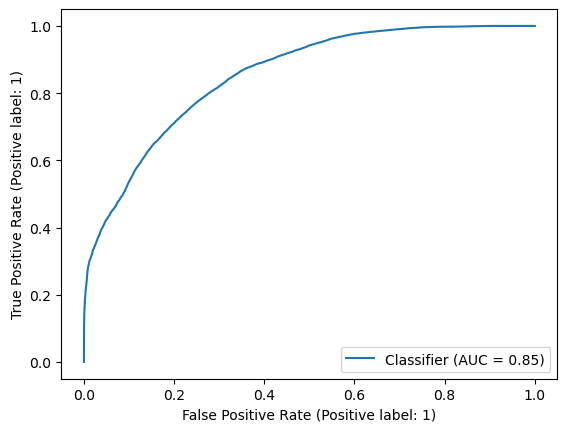

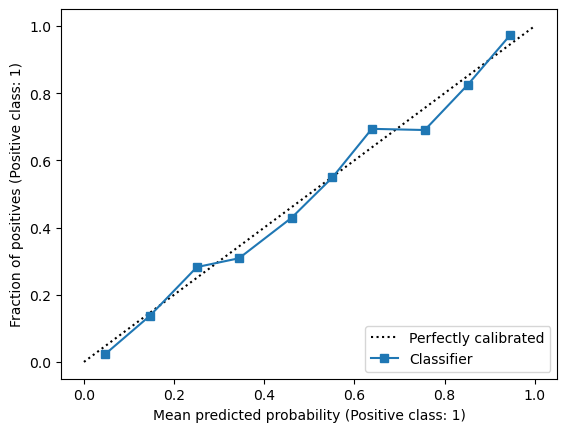

In [16]:
run_name = "Multi Layer Perceptron - test"
additional_description = "Multi Layer Perceptron"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)

        y_proba = model.predict(norm_test)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")